In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(''), "..")))
import example_package
from tqdm import tqdm


%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
def PlotWeights_simple(weights, epoch):
    plt.figure(figsize=(8, 6))
    plt.imshow(weights, cmap='viridis', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title(f'Weight Matrix at Epoch {epoch}')
    plt.xlabel('Units')
    plt.ylabel('Units')
    plt.show()

def VisualizeReconstruction(original, reconstructed):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original.reshape(2, 4), cmap='gray', vmin=-1, vmax=1)
    plt.title("Original Data")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.reshape(2, 4), cmap='gray', vmin=-1, vmax=1)
    plt.title("Reconstructed Data")
    plt.axis('off')

    plt.show()

def plot_hidden_receptive_fields(weights, nv, nh):
    nv1 = nv // 2
    hidden_to_visible = weights[nv1:nv1+nh, :nv1]  # H -> V1 connections
    plt.imshow(hidden_to_visible, cmap='viridis', aspect='auto')
    plt.title("Hidden-to-Visible Weights")
    plt.xlabel("Visible Units (V1)")
    plt.ylabel("Hidden Units")
    plt.colorbar()

In [46]:
def compute_symmetry(matrix_1, matrix_2):
    norm_factor = np.linalg.norm(matrix_1, 'fro') * np.linalg.norm(matrix_2, 'fro')
    if norm_factor == 0:
        return 0
    return np.trace(np.matmul(matrix_1.T, matrix_2)) / norm_factor

def plot_matrices_and_difference(ax_row, matrix_1, matrix_2, title_1, title_2):
    # Plot the first matrix
    im1 = ax_row[0].imshow(matrix_1, cmap='viridis', vmin=-1, vmax=1)
    ax_row[0].set_title(title_1)
    ax_row[0].set_xlabel('Units')
    ax_row[0].set_ylabel('Units')
    plt.colorbar(im1, ax=ax_row[0])
    
    # Plot the second matrix
    im2 = ax_row[1].imshow(matrix_2, cmap='viridis', vmin=-1, vmax=1)
    ax_row[1].set_title(title_2)
    ax_row[1].set_xlabel('Units')
    ax_row[1].set_ylabel('Units')
    plt.colorbar(im2, ax=ax_row[1])
    
    # Plot the difference between the two matrices
    diff = matrix_1 - matrix_2
    im3 = ax_row[2].imshow(diff, cmap='coolwarm', vmin=-1, vmax=1)
    ax_row[2].set_title(f'{title_1} - {title_2}')
    ax_row[2].set_xlabel('Units')
    ax_row[2].set_ylabel('Units')
    plt.colorbar(im3, ax=ax_row[2])

def analyze_symmetry(weight_matrix, nv, nh):
    # Define the structure of the network
    nv1 = nv//2  # Number of visible units in V1
    nv2 = nv//2  # Number of visible units in V2
    nh = 2   # Number of hidden units
    
    # Extract submatrices
    V1 = weight_matrix[:nv1, :nv1]  # V1 to V1 connections
    V2 = weight_matrix[nv1:nv1+nv2, nv1:nv1+nv2]  # V2 to V2 connections
    V1_H = weight_matrix[:nv1, nv1+nv2:nv1+nv2+nh]  # V1 to H connections
    V2_H = weight_matrix[nv1:nv1+nv2, nv1+nv2:nv1+nv2+nh]  # V2 to H connections
    H_V1 = weight_matrix[nv1+nv2:nv1+nv2+nh, :nv1]  # H to V1 connections
    H_V2 = weight_matrix[nv1+nv2:nv1+nv2+nh, nv1:nv1+nv2]  # H to V2 connections
    
    symmetry_V1_V2 = compute_symmetry(V1, V2)
    symmetry_V1_H_V2_H = compute_symmetry(V1_H, V2_H)
    symmetry_H_V1_H_V2 = compute_symmetry(H_V1, H_V2)
    
    return symmetry_V1_V2, symmetry_V1_H_V2_H, symmetry_H_V1_H_V2

def visualize_symmetry(weight_matrix, nv, nh, epoch):
    
    nv1 = nv // 2
    nv2 = nv // 2 
    
    # Extract submatrices
    V1 = weight_matrix[:nv1, :nv1]  # V1 to V1 connections
    V2 = weight_matrix[nv1:nv1+nv2, nv1:nv1+nv2]  # V2 to V2 connections
    V1_H = weight_matrix[:nv1, nv1+nv2:nv1+nv2+nh]  # V1 to H connections
    V2_H = weight_matrix[nv1:nv1+nv2, nv1+nv2:nv1+nv2+nh]  # V2 to H connections
    H_V1 = weight_matrix[nv1+nv2:nv1+nv2+nh, :nv1]  # H to V1 connections
    H_V2 = weight_matrix[nv1+nv2:nv1+nv2+nh, nv1:nv1+nv2]  # H to V2 connections
    
    symmetry_V1_V2 = compute_symmetry(V1, V2)
    symmetry_V1_H_V2_H = compute_symmetry(V1_H, V2_H)
    symmetry_H_V1_H_V2 = compute_symmetry(H_V1, H_V2)
    
    # Visualize the submatrices and their differences
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle(f'Weight Submatrices and Differences at Epoch {epoch}', fontsize=16)
    
    plot_matrices_and_difference(axes[0], V1, V2, 'V1', 'V2')
    plot_matrices_and_difference(axes[1], V1_H, V2_H, 'V1_H', 'V2_H')
    plot_matrices_and_difference(axes[2], H_V1, H_V2, 'H_V1', 'H_V2')
    
    plt.tight_layout()
    plt.show()
    
    return symmetry_V1_V2, symmetry_V1_H_V2_H, symmetry_H_V1_H_V2


def generate_dataset(n_visible):
    pattern_size = min(4, n_visible)
    v_active = torch.zeros((pattern_size, n_visible))

    for i in range(pattern_size):
        v_active[i, (i * (n_visible // pattern_size)) % n_visible] = 1
        v_active[i, (i * (n_visible // pattern_size) + n_visible // 4) % n_visible] = 1
    
    expanded_v_active = v_active.repeat((n_visible // pattern_size, 1))

    expanded_v_active = expanded_v_active[:n_visible, :]

    dataset = -torch.ones((n_visible, 2 * n_visible))  
    dataset[:, :n_visible] += 2 * expanded_v_active

    return dataset


def CreateDecoderAdjacencyMat(n, m, bias):
        # Initialize adjacency matrix
        total_length = 2 * n + m + int(bias)
        adj = np.zeros((total_length, total_length))

        # Connections for V1 (first n units)
        for i in range(n):
            adj[i, 2 * n : 2 * n + m] = 1  # Connect to hidden units only
            adj[i, i] = 0  # No self-connection
            adj[i, n : 2 * n] = 0  # No connections to V2
            adj[i, 0:n] = 0  # No connections to V1 (other visible units)

        # Connections for V2 (next n units)
        for i in range(n, 2 * n):
            adj[i, 2 * n : 2 * n + m] = 1  # Connect to hidden units only
            adj[i, i] = 0  # No self-connection
            adj[i, 0:n] = 0  # No connections to V1
            adj[i, n : 2 * n] = 0  # No connections to V2 (other visible units)

        # Connections for hidden units (last m units)
        for i in range(2 * n, 2 * n + m):
            adj[i, :] = 1  # Connect to all units
            adj[i, 2 * n : 2 * n + m] = 0  # No connections among hidden units

        # Connect bias to all
        if bias:
            adj[total_length - 1, :] = 1
            adj[:, total_length - 1] = 1

        return torch.tensor(adj, dtype=torch.float32)

In [47]:
def new_CreateDecoderAdjacencyMat(n, m,bias):
        # Initialize adjacency matrix
        total_length = 2*n + m + int(bias)
        adj = np.zeros((total_length, total_length))
    
        # Connections for V1 (first n units)
        for i in range(n):
            adj[i, :] = 1  # Connect to all units
            adj[i, i] = 0  # No self-connection
            adj[i, n:n + n] = 0  # No connections to V2
    
        # Connections for V2 (next n units)
        for i in range(n, 2 * n):
            adj[i, :] = 1  # Connect to all units
            adj[i, i] = 0  # No self-connection
            adj[i, 0:n] = 0  # No connections to V1
    
        # Connections for hidden units (last m units)
        for i in range(2 * n, 2 * n + m):
            adj[i, :] = 1  # Connect to all units
            adj[i, 2 * n:2 * n + m] = 0  # No connections among hidden units
        
        #connect bias to all
        if bias:
            adj[total_length-1,:] = 1
            adj[:,total_length-1] = 1
    
        return torch.tensor(adj, dtype=torch.float32)


In [48]:
def TrainBatch(model, data, epochs, n_visible, n_hidden, learningRate, noise_levels, steps_statistics,
               annealing_scheme:float|torch.Tensor,n_steps=None):
        """
        annealing_scheme: temperature, or annealing scheme
        n_steps: number of steps to equilibrium, alternative to specifying a scheme 
        """
        optimizer = optim.SGD(model.parameters(), lr=learningRate)

        symmetry_V1_V2_array = np.zeros(epochs)
        symmetry_V1_H_V2_H_array = np.zeros(epochs)
        symmetry_H_V1_H_V2_array = np.zeros(epochs)

        for iep in tqdm(range(epochs)):
            model.training_step(optimizer,data,noise_levels,steps_statistics,annealing_scheme,n_steps)
            weightmatrix = model.w.detach().cpu().numpy()
            symmetry_V1_V2, symmetry_V1_H_V2_H, symmetry_H_V1_H_V2 = analyze_symmetry(weightmatrix, n_visible, n_hidden)

            symmetry_V1_V2_array[iep] = symmetry_V1_V2
            symmetry_V1_H_V2_H_array[iep] = symmetry_V1_H_V2_H
            symmetry_H_V1_H_V2_array[iep] = symmetry_H_V1_H_V2

        return symmetry_V1_V2_array, symmetry_V1_H_V2_H_array, symmetry_H_V1_H_V2_array

In [49]:
def create_dataset(n_visible):
    id_mat = np.identity(n_visible)
    mat = np.concatenate((id_mat, id_mat), axis=1)
    dataset = torch.tensor(mat, dtype=torch.float32)
    return dataset

In [8]:
"""n_visible = 4
# Define the training set, there are n_visible possible patterns
v_active = torch.tensor([[1, 0, 0, 0, 1, 0, 0, 0],
                        [0, 1, 0, 0, 0, 1, 0, 0],
                        [0, 0, 1, 0, 0, 0, 1, 0],
                        [0, 0, 0, 1, 0, 0, 0, 1]], dtype=torch.float32)
#dataset = -torch.ones((n_visible,2*n_visible))+2*v_active"""

'n_visible = 4\n# Define the training set, there are n_visible possible patterns\nv_active = torch.tensor([[1, 0, 0, 0, 1, 0, 0, 0],\n                        [0, 1, 0, 0, 0, 1, 0, 0],\n                        [0, 0, 1, 0, 0, 0, 1, 0],\n                        [0, 0, 0, 1, 0, 0, 0, 1]], dtype=torch.float32)\n#dataset = -torch.ones((n_visible,2*n_visible))+2*v_active'

## 4-2-4 network 

In [ ]:
n_visible = 4
n_hidden = 2
bias = True
dataset = create_dataset(n_visible)
# Create the adjacency matrix using the external function
adjacency_matrix = new_CreateDecoderAdjacencyMat(n_visible, n_hidden, bias)

#noise_levels = [0.05,0.15]
epochs = 40
learning_rate = 2
noise_levels = [0.05,0.15] # [p_flip_to_zero,p_flip_to_one]
annealing_scheme = torch.Tensor([20,20,15,15,12,12,10,10,10,10])
steps_statistics = 10
n_steps = None
# Make an object from the model and train it
model = example_package.model.BoltzmannMachine(2*n_visible, n_hidden, None, bias)
# Train the model and capture the symmetry values
symmetry_V1_V2, symmetry_V1_H_V2_H, symmetry_H_V1_H_V2 = TrainBatch(
    model, dataset, epochs, 2*n_visible, n_hidden, learning_rate, noise_levels, steps_statistics, annealing_scheme=annealing_scheme, n_steps=n_steps)

100%|██████████| 1000/1000 [04:58<00:00,  3.35it/s]


In [ ]:
#noise_levels = [0.05,0.15]
epochs = 100
learning_rate = 2
noise_levels = [0.05,0.15] # [p_flip_to_zero,p_flip_to_one]
annealing_scheme = torch.Tensor([20,20,15,15,12,12,10,10,10,10])
steps_statistics = 10
# Make an object from the model and train it
model_B = model.BoltzmannMachine(2*n_visible, n_hidden, None, True)
training.TrainBatch(model_B,dataset, epochs, learning_rate,noise_levels,steps_statistics,annealing_scheme)

In [87]:
"""y = model.w.detach().numpy()
y_discrete = np.sign(y)

# Exclude the last row (bin row) from the encodings
encoding_v1 = y_discrete[2*n_visible:-1, :n_visible]  # Exclude the last row
encoding_v2 = y_discrete[2*n_visible:-1, n_visible:2*n_visible]  # Exclude the last row

fig, axes = plt.subplots(2)
im = axes[0].imshow(encoding_v1, cmap='magma')
axes[1].imshow(encoding_v2, cmap='magma')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
axes[0].set_title('Encoding V1')
axes[1].set_title('Encoding V2')
fig.colorbar(im, cax=cbar_ax)
fig.tight_layout()"""

"y = model.w.detach().numpy()\ny_discrete = np.sign(y)\n\n# Exclude the last row (bin row) from the encodings\nencoding_v1 = y_discrete[2*n_visible:-1, :n_visible]  # Exclude the last row\nencoding_v2 = y_discrete[2*n_visible:-1, n_visible:2*n_visible]  # Exclude the last row\n\nfig, axes = plt.subplots(2)\nim = axes[0].imshow(encoding_v1, cmap='magma')\naxes[1].imshow(encoding_v2, cmap='magma')\n\nfig.subplots_adjust(right=0.8)\ncbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])\naxes[0].set_title('Encoding V1')\naxes[1].set_title('Encoding V2')\nfig.colorbar(im, cax=cbar_ax)\nfig.tight_layout()"

In [88]:
"""y=model.w.detach().numpy()
y_discrete = np.sign(y)
fig,axes = plt.subplots(2)
final_index = -1 if bias else len(y_discrete)
encoding_v1 = y_discrete[2*n_visible:final_index,:n_visible]
encoding_v2 = y_discrete[2*n_visible:final_index,n_visible:2*n_visible]
im = axes[0].imshow(encoding_v1,cmap='magma')
axes[1].imshow(encoding_v2,cmap='magma')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
axes[0].set_title('Encoding V1')
axes[1].set_title('Encoding V2')
fig.colorbar(im, cax=cbar_ax)
fig.tight_layout()"""

"y=model.w.detach().numpy()\ny_discrete = np.sign(y)\nfig,axes = plt.subplots(2)\nfinal_index = -1 if bias else len(y_discrete)\nencoding_v1 = y_discrete[2*n_visible:final_index,:n_visible]\nencoding_v2 = y_discrete[2*n_visible:final_index,n_visible:2*n_visible]\nim = axes[0].imshow(encoding_v1,cmap='magma')\naxes[1].imshow(encoding_v2,cmap='magma')\nfig.subplots_adjust(right=0.8)\ncbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])\naxes[0].set_title('Encoding V1')\naxes[1].set_title('Encoding V2')\nfig.colorbar(im, cax=cbar_ax)\nfig.tight_layout()"

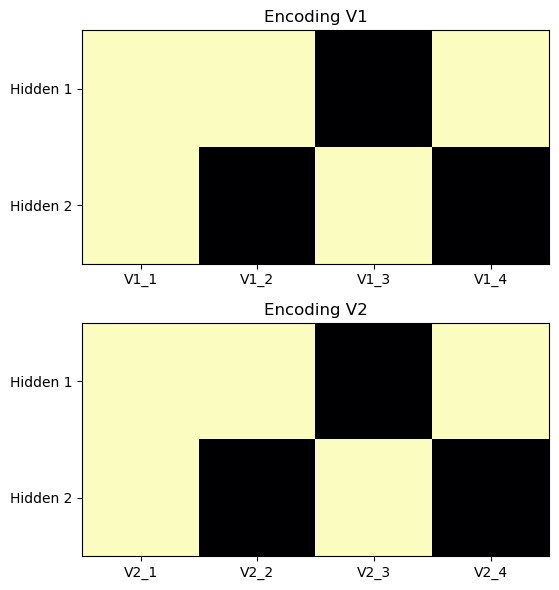

In [90]:
def plot_encodings(n_visible, n_hidden, bias=False):
    # Assuming y is obtained from some model
    y = model.w.detach().numpy()
    y_discrete = np.sign(y)
    final_index = -1 if bias else len(y_discrete)
    
    # Exclude the last row
    encoding_v1 = y_discrete[2*n_visible:final_index-1, :n_visible]  # Exclude last row
    encoding_v2 = y_discrete[2*n_visible:final_index-1, n_visible:2*n_visible]  # Exclude last row

    # Create subplots
    fig, axes = plt.subplots(2, 1, figsize=(8, 6))

    # Plot Encoding V1
    im1 = axes[0].imshow(encoding_v1, cmap='magma', vmin=-1, vmax=1)
    axes[0].set_title('Encoding V1')
    axes[0].set_xticks(np.arange(n_visible))
    axes[0].set_xticklabels([f'V1_{i+1}' for i in range(n_visible)])
    axes[0].set_yticks(np.arange(encoding_v1.shape[0]))  # Adjust y-ticks for remaining rows
    axes[0].set_yticklabels([f'Hidden {i+1}' for i in range(encoding_v1.shape[0])])

    # Plot Encoding V2
    im2 = axes[1].imshow(encoding_v2, cmap='magma', vmin=-1, vmax=1)
    axes[1].set_title('Encoding V2')
    axes[1].set_xticks(np.arange(n_visible))
    axes[1].set_xticklabels([f'V2_{i+1}' for i in range(n_visible)])
    axes[1].set_yticks(np.arange(encoding_v2.shape[0]))  # Adjust y-ticks for remaining rows
    axes[1].set_yticklabels([f'Hidden {i+1}' for i in range(encoding_v2.shape[0])])

    plt.tight_layout()
    plt.show()

# Example usage:
n_visible = 4
n_hidden = 2
bias = False

plot_encodings(n_visible, n_hidden, bias)

In [91]:
import itertools

def hamming_distance(vectors):
    # Generate all unique pairs of vectors
    pairs = itertools.combinations(vectors, 2)
    distances = []
    for v1, v2 in pairs:
        # Calculate Hamming distance for the current pair
        distance = sum(1 for a, b in zip(v1, v2) if a != b)
        distances.append(distance)
    
    mean_distance = sum(distances) / len(distances)
    min_distance = min(distances)
    
    return distances, mean_distance, min_distance

result = hamming_distance(encoding_v1.T)
print(result)

([0, 2, 2, 1, 2, 2, 3, 2, 2, 1, 2, 2, 3, 2, 3, 2, 2, 3, 3, 2, 4, 3, 3, 1, 2, 2, 1, 1], 2.0714285714285716, 0)


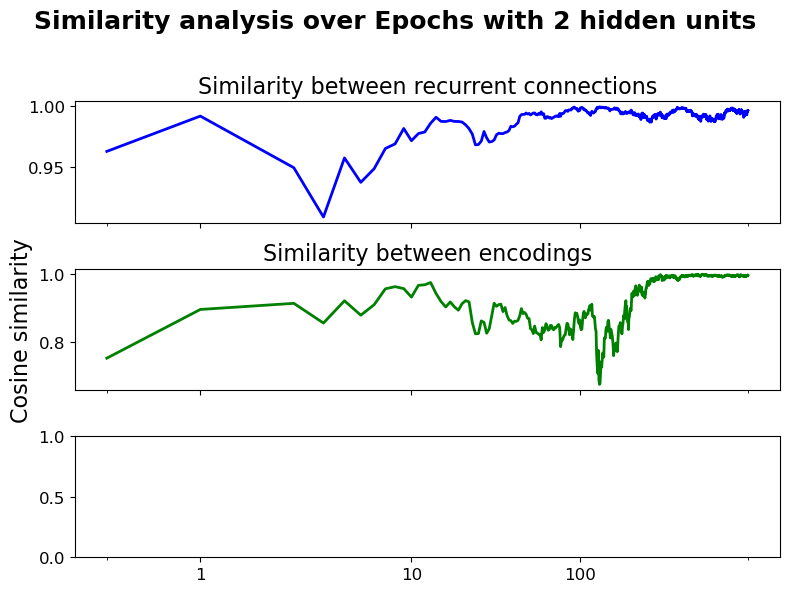

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a single figure with three subplots, adjusting figure size
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 6))  # Increased size
fig.suptitle("Similarity analysis over Epochs with 2 hidden units", fontsize=18, fontweight='bold')

# Define larger font sizes for better readability
label_fontsize = 16
title_fontsize = 16
tick_fontsize = 12
legend_fontsize = 12

epochs_array = np.arange(epochs) + 1e-6  # Add small constant to avoid log(0)

# First plot
axes[0].plot(epochs_array, symmetry_V1_V2, color='blue', linewidth=2)
axes[0].set_title("Similarity between recurrent connections", fontsize=title_fontsize)
axes[0].set_xscale('symlog')

# Second plot (Middle one - Only this gets the y-axis label)
axes[1].plot(epochs_array, symmetry_V1_H_V2_H, color='green', linewidth=2)
axes[1].set_ylabel("Cosine similarity", fontsize=label_fontsize)
axes[1].set_title("Similarity between encodings", fontsize=title_fontsize)
axes[1].set_xscale('symlog')

# Third plot
axes[2].plot(epochs_array, symmetry_H_V1_H_V2, color='red', linewidth=2)
axes[2].set_xlabel("Epochs", fontsize=label_fontsize)
axes[2].set_title("Similarity between encodings", fontsize=title_fontsize)
axes[2].set_xscale('symlog')

# Set fixed x-axis ticks at 1, 10, and 100
fixed_ticks = [1, 10, 100]
axes[2].set_xticks(fixed_ticks)
axes[2].set_xticklabels([str(tick) for tick in fixed_ticks])  # Ensure labels are strings

# Remove grid and increase tick font size
for ax in axes:
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.grid(False)

# Adjust layout to fit title
plt.tight_layout(rect=[0, 0, 1, 0.96])
#plt.savefig("similarity_analysis.pdf", format="pdf", bbox_inches="tight")
plt.show()

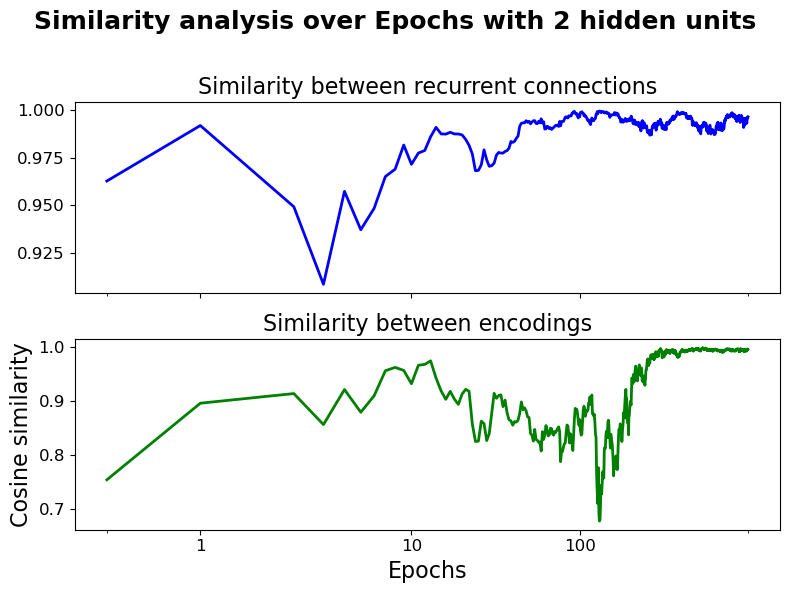

In [102]:
import matplotlib.pyplot as plt
import numpy as np

# Create a single figure with two subplots, adjusting figure size
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 6))  # Two subplots, increased size
fig.suptitle("Similarity analysis over Epochs with 2 hidden units", fontsize=18, fontweight='bold')

# Define larger font sizes for better readability
label_fontsize = 16
title_fontsize = 16
tick_fontsize = 12
legend_fontsize = 12

epochs_array = np.arange(epochs) + 1e-6  # Add small constant to avoid log(0)

# First plot
axes[0].plot(epochs_array, symmetry_V1_V2, color='blue', linewidth=2)
axes[0].set_title("Similarity between recurrent connections", fontsize=title_fontsize)
axes[0].set_xscale('symlog')

# Second plot (Now the bottom plot - This gets the x-axis label and ticks)
axes[1].plot(epochs_array, symmetry_V1_H_V2_H, color='green', linewidth=2)
axes[1].set_ylabel("Cosine similarity", fontsize=label_fontsize)
axes[1].set_title("Similarity between encodings", fontsize=title_fontsize)
axes[1].set_xscale('symlog')
axes[1].set_xlabel("Epochs", fontsize=label_fontsize)  # Add x-axis label to the second plot

# Set fixed x-axis ticks at 1, 10, and 100
fixed_ticks = [1, 10, 100]
axes[1].set_xticks(fixed_ticks)
axes[1].set_xticklabels([str(tick) for tick in fixed_ticks])  # Ensure labels are strings

# Remove grid and increase tick font size
for ax in axes:
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.grid(False)

# Adjust layout to fit title
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("similarity_analysis_new.png", bbox_inches="tight")
plt.show()

#numpy.logspaced then calculate it only for logspaaced 

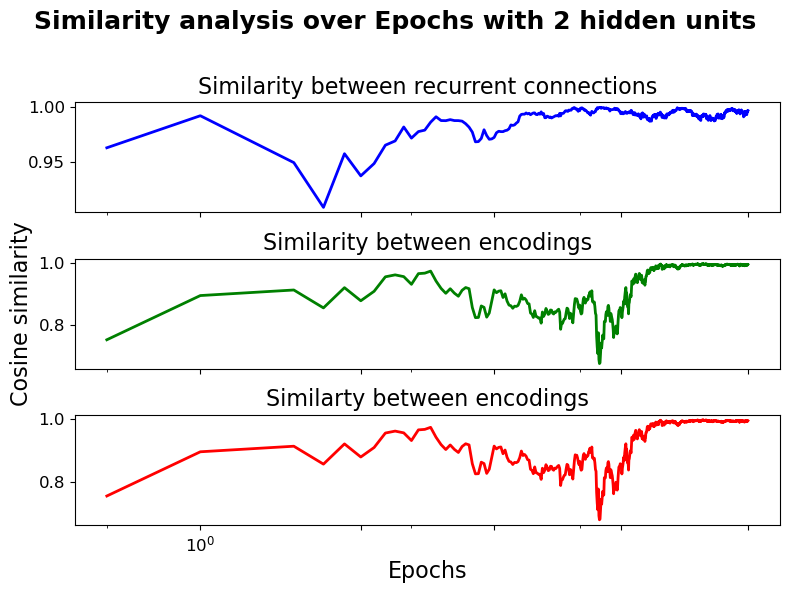

In [93]:
# Create a single figure with three subplots, adjusting figure size
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 6))  # Increased size
fig.suptitle("Similarity analysis over Epochs with 2 hidden units", fontsize=18, fontweight='bold')

# Define larger font sizes for better readability
label_fontsize = 16
title_fontsize = 16
tick_fontsize = 12
legend_fontsize = 12

epochs_array = np.arange(epochs) + 1e-6  # Add small constant to avoid log(0)

# First plot
axes[0].plot(epochs_array, symmetry_V1_V2, color='blue', linewidth=2)
axes[0].set_title("Similarity between recurrent connections", fontsize=title_fontsize)
axes[0].set_xscale('symlog')

# Second plot (Middle one - Only this gets the y-axis label)
axes[1].plot(epochs_array, symmetry_V1_H_V2_H, color='green', linewidth=2)
axes[1].set_ylabel("Cosine similarity", fontsize=label_fontsize)
axes[1].set_title("Similarity between encodings", fontsize=title_fontsize)
axes[1].set_xscale('symlog')

# Third plot
axes[2].plot(epochs_array, symmetry_H_V1_H_V2, color='red', linewidth=2)
axes[2].set_xlabel("Epochs", fontsize=label_fontsize)
axes[2].set_title("Similarty between encodings", fontsize=title_fontsize)
axes[2].set_xscale('symlog')

# Adjust x-axis ticks for readability
axes[2].set_xticks(np.logspace(0, np.log10(epochs - 1), num=5, dtype=int))  # Log-spaced ticks

# Remove grid and increase tick font size
for ax in axes:
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.grid(False)

# Adjust layout to fit title
plt.tight_layout(rect=[0, 0, 1, 0.96])
#plt.savefig("similarity_analysis.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [9]:
n_hidden = 4
bias = True
# Create the adjacency matrix using the external function
adjacency_matrix = CreateDecoderAdjacencyMat(n_visible, n_hidden, bias)

#noise_levels = [0.05,0.15]
epochs = 150
learning_rate = 2
noise_levels = [0.05,0.15] # [p_flip_to_zero,p_flip_to_one]
annealing_scheme = torch.Tensor([20,20,15,15,12,12,10,10,10,10])
steps_statistics = 10
n_steps = None
# Make an object from the model and train it
model = example_package.BoltzmannMachine(2*n_visible, n_hidden, adjacency_matrix, bias, mode='bipolar')
# Train the model and capture the symmetry values
symmetry_V1_V2, symmetry_V1_H_V2_H, symmetry_H_V1_H_V2 = TrainBatch(
    model, dataset, epochs, 2*n_visible, n_hidden, learning_rate, noise_levels, steps_statistics, annealing_scheme=annealing_scheme, n_steps=n_steps)

Parameter containing:
tensor([[ 0.0000e+00,  9.0000e-01,  2.0000e-01, -2.0000e-01,  1.9000e+00,
         -1.0000e-01,  2.0000e-01,  0.0000e+00, -1.0000e-01, -3.0000e-01,
          6.0000e-01, -2.0000e-01, -1.5000e+00],
        [ 9.0000e-01,  0.0000e+00,  1.1000e+00,  1.3000e+00,  1.2000e+00,
          1.6000e+00,  9.0000e-01,  1.1000e+00,  6.0000e-01,  4.0000e-01,
         -3.0000e-01, -5.0000e-01, -1.8000e+00],
        [ 2.0000e-01,  1.1000e+00,  0.0000e+00, -2.0000e-01, -1.0000e-01,
         -5.0000e-01,  2.2000e+00, -4.0000e-01,  3.0000e-01,  7.0000e-01,
          2.0000e-01,  4.0000e-01, -1.3000e+00],
        [-2.0000e-01,  1.3000e+00, -2.0000e-01,  0.0000e+00, -1.0000e-01,
         -1.0000e-01,  0.0000e+00,  2.0000e+00,  5.0000e-01,  5.0000e-01,
          2.0000e-01, -4.0000e-01, -1.1000e+00],
        [ 1.9000e+00,  1.2000e+00, -1.0000e-01, -1.0000e-01,  0.0000e+00,
         -6.0000e-01, -1.0000e-01, -3.0000e-01, -1.4901e-08, -1.4901e-08,
          1.0000e-01,  3.0000e-01, -4.0000

/tmp/ipykernel_84061/1751476644.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


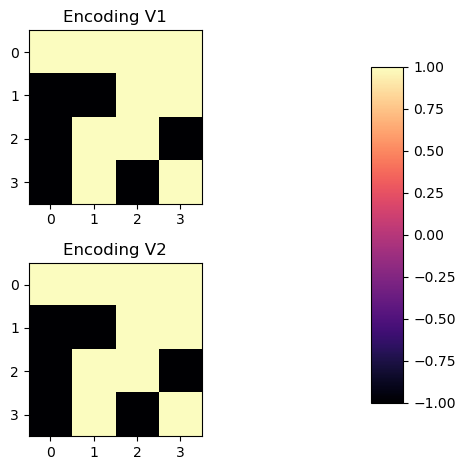

In [10]:
y=model.w.detach().numpy()
y_discrete = np.sign(y)
fig,axes = plt.subplots(2)
final_index = -1 if bias else len(y_discrete)
encoding_v1 = y_discrete[2*n_visible:final_index,:n_visible]
encoding_v2 = y_discrete[2*n_visible:final_index,n_visible:2*n_visible]
im = axes[0].imshow(encoding_v1,cmap='magma')
axes[1].imshow(encoding_v2,cmap='magma')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
axes[0].set_title('Encoding V1')
axes[1].set_title('Encoding V2')
fig.colorbar(im, cax=cbar_ax)
fig.tight_layout()

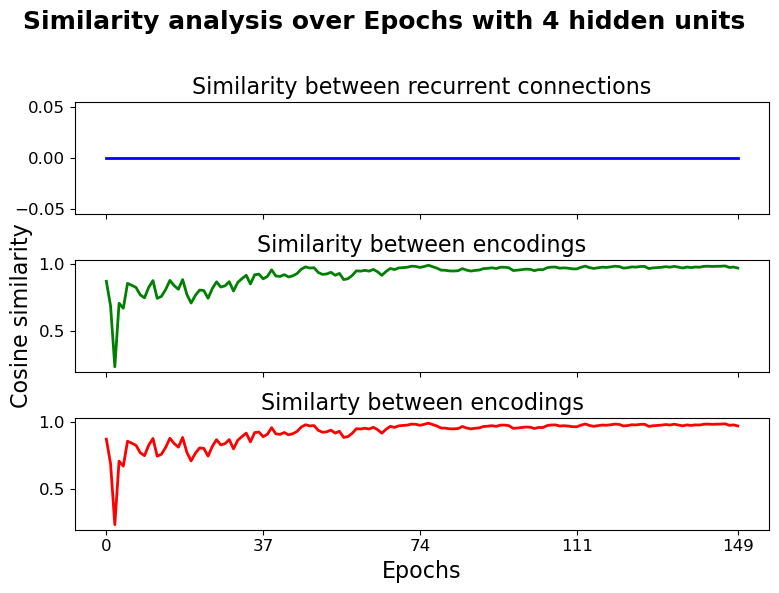

In [11]:
epochs_array = np.arange(epochs)
# Create a single figure with three subplots, adjusting figure size
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 6))  # Increased size
fig.suptitle("Similarity analysis over Epochs with 4 hidden units", fontsize=18, fontweight='bold')

# Define larger font sizes for better readability
label_fontsize = 16
title_fontsize = 16
tick_fontsize = 12
legend_fontsize = 12

# First plot
axes[0].plot(epochs_array, symmetry_V1_V2, color='blue', linewidth=2)
axes[0].set_title("Similarity between recurrent connections", fontsize=title_fontsize)
#axes[0].legend(fontsize=legend_fontsize)

# Second plot (Middle one - Only this gets the y-axis label)
axes[1].plot(epochs_array, symmetry_V1_H_V2_H, color='green', linewidth=2)
axes[1].set_ylabel("Cosine similarity", fontsize=label_fontsize)
axes[1].set_title("Similarity between encodings", fontsize=title_fontsize)
#axes[1].legend(fontsize=legend_fontsize)

# Third plot
axes[2].plot(epochs_array, symmetry_H_V1_H_V2, color='red', linewidth=2)
axes[2].set_xlabel("Epochs", fontsize=label_fontsize)
axes[2].set_title("Similarty between encodings", fontsize=title_fontsize)
#axes[2].legend(fontsize=legend_fontsize)

# Adjust x-axis ticks for readability
axes[2].set_xticks(np.linspace(0, epochs - 1, num=5, dtype=int))  # Fewer ticks

# Remove grid and increase tick font size
for ax in axes:
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.grid(False)

# Adjust layout to fit title
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("similarity_analysis.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [12]:
n_hidden = 8
bias = True
# Create the adjacency matrix using the external function
adjacency_matrix = CreateDecoderAdjacencyMat(n_visible, n_hidden, bias)

#noise_levels = [0.05,0.15]
epochs = 150
learning_rate = 2
noise_levels = [0.05,0.15] # [p_flip_to_zero,p_flip_to_one]
annealing_scheme = torch.Tensor([20,20,15,15,12,12,10,10,10,10])
steps_statistics = 10
n_steps = None
# Make an object from the model and train it
model = example_package.BoltzmannMachine(2*n_visible, n_hidden, adjacency_matrix, bias, mode='bipolar')
# Train the model and capture the symmetry values
symmetry_V1_V2, symmetry_V1_H_V2_H, symmetry_H_V1_H_V2 = TrainBatch(
    model, dataset, epochs, 2*n_visible, n_hidden, learning_rate, noise_levels, steps_statistics, annealing_scheme=annealing_scheme, n_steps=n_steps)

Parameter containing:
tensor([[ 0.0000e+00, -3.0000e-01, -4.0000e-01,  0.0000e+00,  2.0000e+00,
         -1.2000e+00, -4.0000e-01, -5.0000e-01, -1.0000e-01,  2.0000e-01,
         -1.0000e-01,  1.0000e-01, -2.0000e-01,  0.0000e+00, -4.0000e-01,
         -1.0000e-01, -1.2000e+00],
        [-3.0000e-01,  0.0000e+00,  3.0000e-01,  1.0000e-01, -1.0000e-01,
          1.1000e+00, -3.0000e-01, -6.0000e-01, -4.0000e-01, -5.0000e-01,
          4.0000e-01,  4.0000e-01,  5.0000e-01,  1.0000e-01, -1.0000e-01,
          2.0000e-01, -1.3000e+00],
        [-4.0000e-01,  3.0000e-01,  0.0000e+00,  4.0000e-01,  7.4506e-09,
         -6.0000e-01,  1.6000e+00, -3.0000e-01,  3.0000e-01,  6.0000e-01,
         -1.0000e-01, -3.0000e-01, -6.0000e-01,  0.0000e+00,  2.0000e-01,
         -1.0000e-01, -1.6000e+00],
        [ 0.0000e+00,  1.0000e-01,  4.0000e-01,  0.0000e+00, -4.0000e-01,
          8.0000e-01,  4.0000e-01,  1.9000e+00, -3.0000e-01, -2.0000e-01,
          3.0000e-01, -1.0000e-01,  4.0000e-01,  1.4901e

/tmp/ipykernel_84061/1751476644.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


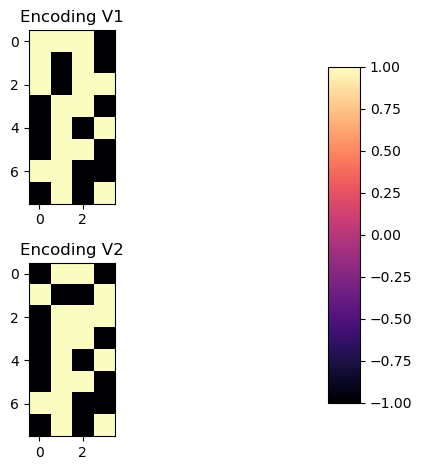

In [13]:
y=model.w.detach().numpy()
y_discrete = np.sign(y)
fig,axes = plt.subplots(2)
final_index = -1 if bias else len(y_discrete)
encoding_v1 = y_discrete[2*n_visible:final_index,:n_visible]
encoding_v2 = y_discrete[2*n_visible:final_index,n_visible:2*n_visible]
im = axes[0].imshow(encoding_v1,cmap='magma')
axes[1].imshow(encoding_v2,cmap='magma')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
axes[0].set_title('Encoding V1')
axes[1].set_title('Encoding V2')
fig.colorbar(im, cax=cbar_ax)
fig.tight_layout()

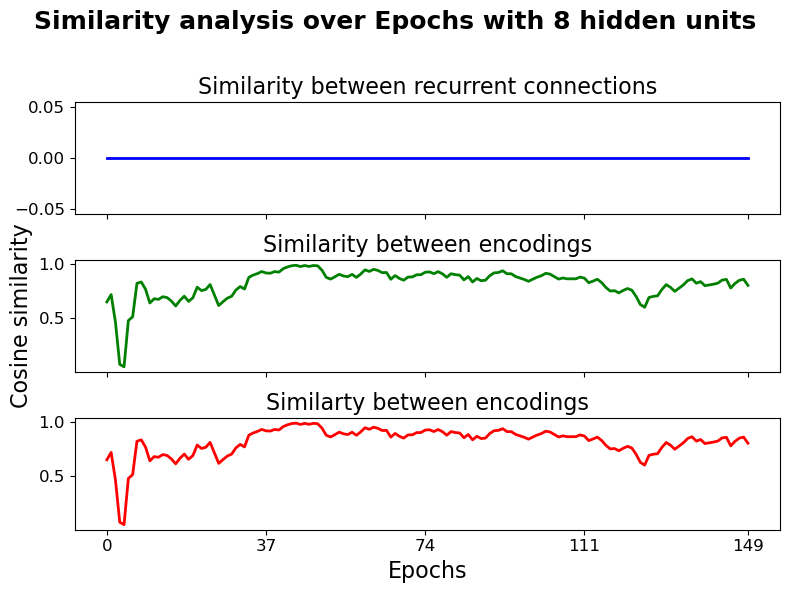

In [14]:
epochs_array = np.arange(epochs)
# Create a single figure with three subplots, adjusting figure size
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 6))  # Increased size
fig.suptitle("Similarity analysis over Epochs with 8 hidden units", fontsize=18, fontweight='bold')

# Define larger font sizes for better readability
label_fontsize = 16
title_fontsize = 16
tick_fontsize = 12
legend_fontsize = 12

# First plot
axes[0].plot(epochs_array, symmetry_V1_V2, color='blue', linewidth=2)
axes[0].set_title("Similarity between recurrent connections", fontsize=title_fontsize)
#axes[0].legend(fontsize=legend_fontsize)

# Second plot (Middle one - Only this gets the y-axis label)
axes[1].plot(epochs_array, symmetry_V1_H_V2_H, color='green', linewidth=2)
axes[1].set_ylabel("Cosine similarity", fontsize=label_fontsize)
axes[1].set_title("Similarity between encodings", fontsize=title_fontsize)
#axes[1].legend(fontsize=legend_fontsize)

# Third plot
axes[2].plot(epochs_array, symmetry_H_V1_H_V2, color='red', linewidth=2)
axes[2].set_xlabel("Epochs", fontsize=label_fontsize)
axes[2].set_title("Similarty between encodings", fontsize=title_fontsize)
#axes[2].legend(fontsize=legend_fontsize)

# Adjust x-axis ticks for readability
axes[2].set_xticks(np.linspace(0, epochs - 1, num=5, dtype=int))  # Fewer ticks

# Remove grid and increase tick font size
for ax in axes:
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.grid(False)

# Adjust layout to fit title
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("similarity_analysis.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [15]:
n_hidden = 12
bias = True
# Create the adjacency matrix using the external function
adjacency_matrix = CreateDecoderAdjacencyMat(n_visible, n_hidden, bias)

#noise_levels = [0.05,0.15]
epochs = 150
learning_rate = 2
noise_levels = [0.05,0.15] # [p_flip_to_zero,p_flip_to_one]
annealing_scheme = torch.Tensor([20,20,15,15,12,12,10,10,10,10])
steps_statistics = 10
n_steps = None
# Make an object from the model and train it
model = example_package.BoltzmannMachine(2*n_visible, n_hidden, adjacency_matrix, bias, mode='bipolar')
# Train the model and capture the symmetry values
symmetry_V1_V2, symmetry_V1_H_V2_H, symmetry_H_V1_H_V2 = TrainBatch(
    model, dataset, epochs, 2*n_visible, n_hidden, learning_rate, noise_levels, steps_statistics, annealing_scheme=annealing_scheme, n_steps=n_steps)

Parameter containing:
tensor([[ 0.0000e+00,  7.0000e-01,  1.0000e-01,  1.7000e+00,  1.8000e+00,
          9.0000e-01,  4.0000e-01,  1.0000e-01,  1.0000e-01,  1.0000e-01,
          3.0000e-01,  3.0000e-01,  6.0000e-01, -4.0000e-01,  5.0000e-01,
         -1.0000e-01, -2.0000e-01,  2.0000e-01, -5.0000e-01, -1.4901e-08,
         -1.0000e+00],
        [ 7.0000e-01,  0.0000e+00, -1.0000e+00,  8.0000e-01,  1.1000e+00,
         -2.0000e-01, -7.0000e-01,  6.0000e-01,  2.0000e-01,  0.0000e+00,
         -2.0000e-01, -2.0000e-01, -3.0000e-01, -1.0000e-01,  6.0000e-01,
         -2.0000e-01,  1.0000e-01,  1.0000e-01,  2.0000e-01, -9.0000e-01,
          5.0000e-01],
        [ 1.0000e-01, -1.0000e+00,  0.0000e+00, -4.0000e-01,  5.0000e-01,
          1.0000e+00,  2.1000e+00, -6.0000e-01,  2.0000e-01, -2.0000e-01,
         -4.0000e-01,  2.0000e-01, -7.0000e-01,  9.0000e-01,  0.0000e+00,
          4.0000e-01, -1.0000e-01,  5.0000e-01,  2.0000e-01,  9.0000e-01,
         -1.7000e+00],
        [ 1.7000e+00,

/tmp/ipykernel_84061/277891091.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


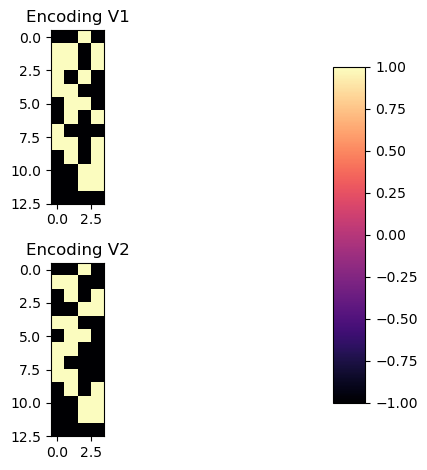

In [16]:
y=model.w.detach().numpy()
y_discrete = np.sign(y)
fig,axes = plt.subplots(2)
encoding_v1 = y_discrete[2*n_visible:,:n_visible]
encoding_v2 = y_discrete[2*n_visible:,n_visible:2*n_visible]
im = axes[0].imshow(encoding_v1,cmap='magma')
axes[1].imshow(encoding_v2,cmap='magma')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
axes[0].set_title('Encoding V1')
axes[1].set_title('Encoding V2')
fig.colorbar(im, cax=cbar_ax)
fig.tight_layout()

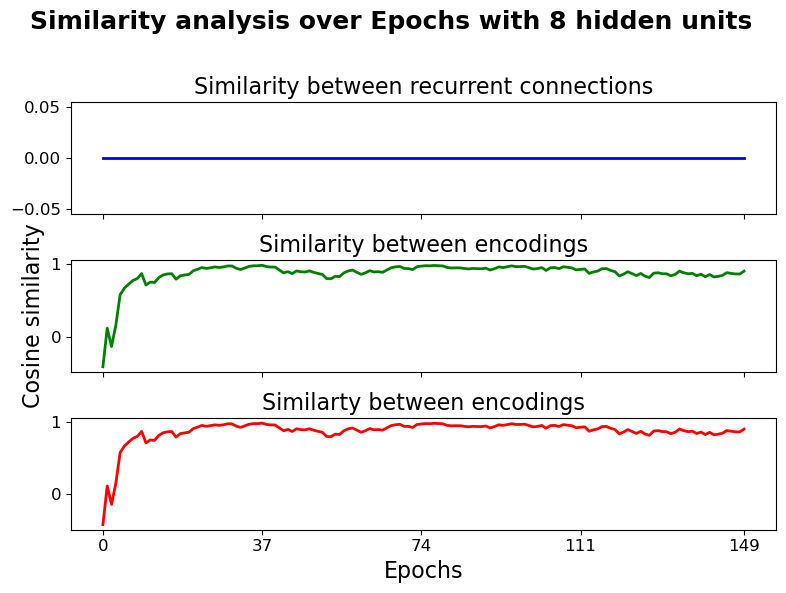

In [17]:
epochs_array = np.arange(epochs)
# Create a single figure with three subplots, adjusting figure size
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 6))  # Increased size
fig.suptitle("Similarity analysis over Epochs with 8 hidden units", fontsize=18, fontweight='bold')

# Define larger font sizes for better readability
label_fontsize = 16
title_fontsize = 16
tick_fontsize = 12
legend_fontsize = 12

# First plot
axes[0].plot(epochs_array, symmetry_V1_V2, color='blue', linewidth=2)
axes[0].set_title("Similarity between recurrent connections", fontsize=title_fontsize)
#axes[0].legend(fontsize=legend_fontsize)

# Second plot (Middle one - Only this gets the y-axis label)
axes[1].plot(epochs_array, symmetry_V1_H_V2_H, color='green', linewidth=2)
axes[1].set_ylabel("Cosine similarity", fontsize=label_fontsize)
axes[1].set_title("Similarity between encodings", fontsize=title_fontsize)
#axes[1].legend(fontsize=legend_fontsize)

# Third plot
axes[2].plot(epochs_array, symmetry_H_V1_H_V2, color='red', linewidth=2)
axes[2].set_xlabel("Epochs", fontsize=label_fontsize)
axes[2].set_title("Similarty between encodings", fontsize=title_fontsize)
#axes[2].legend(fontsize=legend_fontsize)

# Adjust x-axis ticks for readability
axes[2].set_xticks(np.linspace(0, epochs - 1, num=5, dtype=int))  # Fewer ticks

# Remove grid and increase tick font size
for ax in axes:
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.grid(False)

# Adjust layout to fit title
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("similarity_analysis.pdf", format="pdf", bbox_inches="tight")
plt.show()